UCI dataset loaded: (297, 14)
Kaggle dataset loaded: (1025, 14)
Merged dataset shape: (1322, 14)

===== MODEL COMPARISON =====
Logistic Regression Accuracy: 65.28%
Random Forest Accuracy:       93.58%
XGBoost Accuracy:             93.96%
SHAP returned a 3D array (New behavior)
Shape of SHAP values: (265, 13)
Shape of X_test: (265, 13)

SHAP Summary Plot:


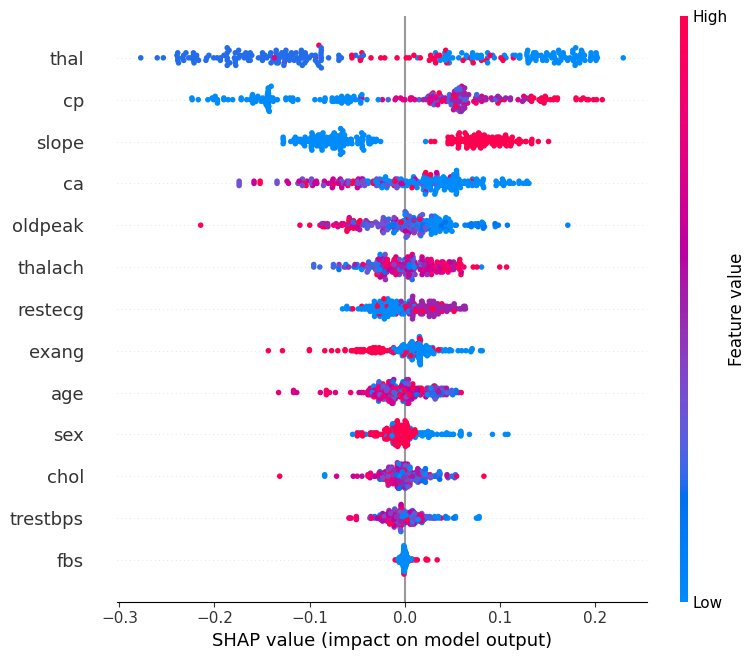


SHAP Feature Importance:


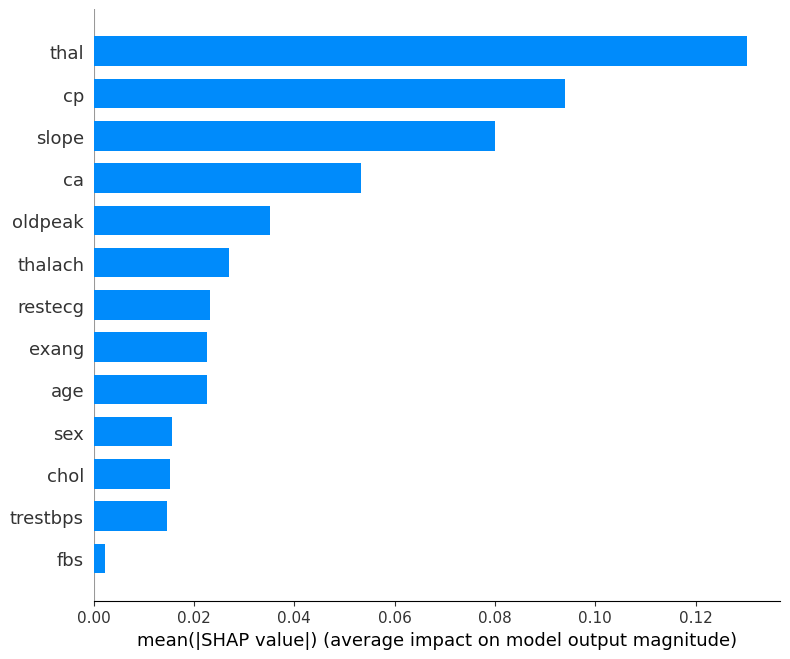


Showing SHAP force plot for first test sample…


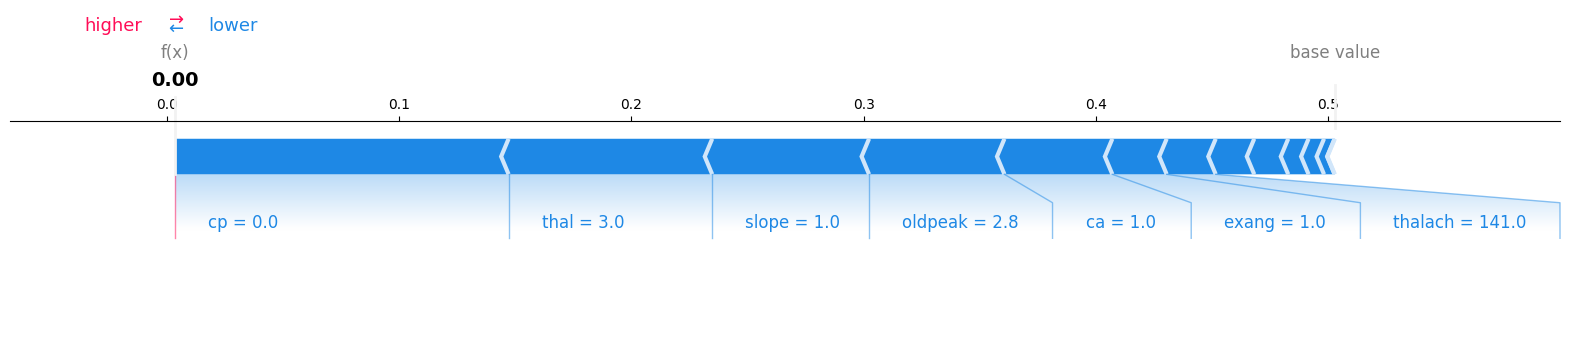


✅ SUCCESS: Random Forest Model & Scaler Saved!


In [2]:
# -----------------------------------------------------------
# 1) Install Libraries (if needed)
# -----------------------------------------------------------
# -----------------------------------------------------------
# 2) Import
# -----------------------------------------------------------
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
import kagglehub
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
import os
import joblib
warnings.filterwarnings("ignore")

# -----------------------------------------------------------
# 3) Load UCI Dataset (Cleveland Data)
# -----------------------------------------------------------
uci_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

uci_cols = [
    "age","sex","cp","trestbps","chol","fbs","restecg","thalach",
    "exang","oldpeak","slope","ca","thal","target"
]

uci_data = pd.read_csv(uci_url, header=None, names=uci_cols)
uci_data.replace("?", np.nan, inplace=True)
uci_data.dropna(inplace=True)
uci_data["ca"] = uci_data["ca"].astype(float)
uci_data["thal"] = uci_data["thal"].astype(float)

# UCI target: 0 = healthy, 1–4 = disease → Convert all to binary
uci_data["target"] = (uci_data["target"] > 0).astype(int)

print("UCI dataset loaded:", uci_data.shape)

# -----------------------------------------------------------
# 4) Load Kaggle Dataset
# -----------------------------------------------------------
print("Downloading Kaggle dataset...")
path = kagglehub.dataset_download("johnsmith88/heart-disease-dataset")

csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
csv_path = os.path.join(path, csv_files[0])
kaggle_data = pd.read_csv(csv_path)

print("Kaggle dataset loaded:", kaggle_data.shape)

# -----------------------------------------------------------
# 5) Unify Column Names
# -----------------------------------------------------------
kaggle_data.columns = [
    "age","sex","cp","trestbps","chol","fbs","restecg","thalach",
    "exang","oldpeak","slope","ca","thal","target"
]

# -----------------------------------------------------------
# 6) Combine Both Datasets
# -----------------------------------------------------------
full_data = pd.concat([uci_data, kaggle_data], ignore_index=True)

print("Merged dataset shape:", full_data.shape)

# -----------------------------------------------------------
# 7) Split X, y
# -----------------------------------------------------------
X = full_data.drop("target", axis=1)
y = full_data["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------------------------------------------
# 8) Scaling
# -----------------------------------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -----------------------------------------------------------
# 9) Train Models
# -----------------------------------------------------------

# Logistic Regression
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train)
log_pred = log_model.predict(X_test_scaled)

# Random Forest
rf_model = RandomForestClassifier(
    n_estimators=350,
    max_depth=10,
    random_state=42
)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=350,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# -----------------------------------------------------------
# 10) Print Accuracy Results
# -----------------------------------------------------------
print("\n===== MODEL COMPARISON =====")
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, log_pred)*100:.2f}%")
print(f"Random Forest Accuracy:       {accuracy_score(y_test, rf_pred)*100:.2f}%")
print(f"XGBoost Accuracy:             {accuracy_score(y_test, xgb_pred)*100:.2f}%")
# -----------------------------------------------------------
# 11) SHAP Explainability (Fixed for Random Forest)
# -----------------------------------------------------------
import shap
import numpy as np
import matplotlib.pyplot as plt

# 1. حساب قيم SHAP
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# 2. استخراج القيم الخاصة بـ Class 1 (المرض) بشكل صحيح
# بنفحص نوع الناتج عشان نتفادى الخطأ مهما كان الإصدار
if isinstance(shap_values, list):
    # الطريقة القديمة: قائمة تحتوي على مصفوفة لكل Class
    print("SHAP returned a list (Standard Sklearn behavior)")
    shap_vals_target = shap_values[1]
elif len(np.array(shap_values).shape) == 3:
    # الطريقة الحديثة: مصفوفة ثلاثية الأبعاد (Samples, Features, Classes)
    print("SHAP returned a 3D array (New behavior)")
    shap_vals_target = shap_values[:, :, 1]
else:
    # حالة خاصة (Regression أو غيره)
    print("SHAP returned a 2D array")
    shap_vals_target = shap_values

print(f"Shape of SHAP values: {np.array(shap_vals_target).shape}")
print(f"Shape of X_test: {X_test.shape}")

# 3. الرسم (Summary Plot)
print("\nSHAP Summary Plot:")
plt.figure() # لضمان عدم تداخل الرسومات
shap.summary_plot(shap_vals_target, X_test)

# 4. الرسم (Feature Importance Bar)
print("\nSHAP Feature Importance:")
plt.figure()
shap.summary_plot(shap_vals_target, X_test, plot_type="bar")

# -----------------------------------------------------------
# 12) SHAP Force Plot (لأول مريض)
# -----------------------------------------------------------
shap.initjs()

print("\nShowing SHAP force plot for first test sample…")
# نجهز القيمة المتوقعة (Base Value)
expected_val = explainer.expected_value
if isinstance(expected_val, list) or isinstance(expected_val, np.ndarray):
    if len(np.array(expected_val).shape) > 0:
        expected_val = expected_val[1]

# رسم الحالة
shap.force_plot(
    expected_val,
    shap_vals_target[0],
    X_test.iloc[0],
    matplotlib=True
)

# -----------------------------------------------------------
# 13) Save Final Model
# -----------------------------------------------------------
import joblib
joblib.dump(rf_model, "heart_disease_model.pkl")
joblib.dump(scaler, "scaler.pkl")
print("\n✅ SUCCESS: Random Forest Model & Scaler Saved!")
